In [1]:
import pandas as pd
from Genome.goldstandard_pair.lls import *

In [2]:
help(read_gold)

Help on function read_gold in module Genome.goldstandard_pair.lls:

read_gold(gd)
    reads goldstandard file, returns dataframe
    input: gd = csv file containing goldstandard data, preferably sampled
    output: df, header = ['gene_one, 'gene_two', 'goldstandard']



In [3]:
gd = '/home/hermuba/data0118/goldstandard/tf_intersectGO.smpl'
gold= read_gold(gd)

In [10]:
gold.head()

,gene_one,gene_two,goldstandard
0,562.22936.con.0094_4|562.22936,562.23583.con.0117_6|562.23583,0
1,562.22913.con.0024_38|562.22913,562.22651.con.0028_42|562.22651,1
2,562.22936.con.0027_15|562.22936,FLWH01000001_736|562.12962,0
3,562.23714.con.0031_3|562.23714,JMUY01000008_141|1438670.3,0
4,562.23205.con.0005_5|562.23205,562.22520.con.0145_5|562.22520,0


In [11]:
help(read_net_by_chunk)

Help on function read_net_by_chunk in module Genome.goldstandard_pair.lls:

read_net_by_chunk(net)
    read network file chunk by chunk, 100000 lines for a time
    input: file path



In [12]:
help(merge_net_with_all_chunks)

Help on function merge_net_with_all_chunks in module Genome.goldstandard_pair.lls:

merge_net_with_all_chunks(gold, all_chunks)
    returns merged goldstardard and score



In [13]:
all_chunks = read_net_by_chunk('/home/hermuba/data0118/domain_weight_mutual')
all_df = merge_net_with_all_chunks(gold, all_chunks)

In [ ]:
all_df.head()

In [ ]:
help(lls)

In [130]:
lls_score = lls(all_df)

NameError: name 'd' is not defined

In [69]:
def return_stats(d):
    '''
    input: dataframe from `to_df`
    output: stats representing true and false interacting pairs
    '''
    
    d.boxplot(column = ['weighted_mutual'], by = 'goldstandard')
    group_d = d.groupby(by = 'goldstandard')
    
    return(group_d[['weighted_mutual']].describe())
def kde_d(d):
    
    group_d = d.groupby(by = 'goldstandard')
    
    group_d['weighted_mutual'].plot(kind = 'kde', legend = True, title = 'weighted_mutual')
    

def LLS(d, score):
    # seperate mutual info score into 100 categories
    d['cut_mutual'] = pd.qcut(d[score],  200)
    grouped = d.groupby(by = ['goldstandard', 'cut_mutual']).count()['gene_one']
    grouped = grouped.fillna(0)
    lls = grouped[1]/grouped[0]/(grouped[1].sum()/grouped[0].sum())
    lls.plot()
    return(lls)


In [26]:
return_stats(total_path)

weighted_mutual                                                  \
                       count      mean       std           min           25%   
goldstandard                                                                   
0                     3844.0  0.000001  0.000018  1.454694e-10  3.277658e-08   
1                      135.0  0.000734  0.000782  2.967224e-08  5.283995e-05   

                                                    
                       50%           75%       max  
goldstandard                                        
0             9.592633e-08  2.109260e-07  0.000767  
1             7.169488e-04  1.006357e-03  0.004082

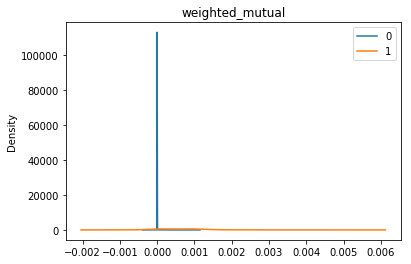

In [27]:
kde_d(total_path)

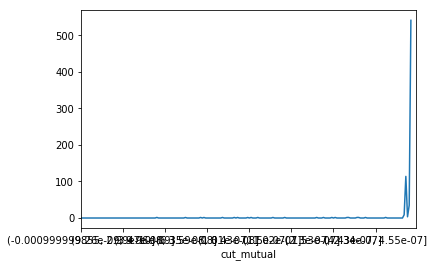

In [101]:
lls = LLS(total_path, 'weighted_mutual')

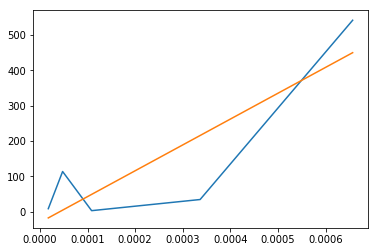

In [99]:
# regressing
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import linregress
clean_lls = lls.replace([np.inf, -np.inf, 0], np.nan)                                                 
clean_lls.dropna(inplace = True)                                                                
thres = next(x[0] for x in enumerate(clean_lls) if x[1] > 3)
rm_lls = clean_lls[thres:]
x = np.array([i.mid for i in rm_lls.index])
y = rm_lls.values
plt.plot(x,y)

slope, intercept, r_value, p_value, std_err = linregress(x,y)
plt.plot(x, slope*x+intercept)

In [104]:
# compare lls
x = np.array([interval.mid for interval in lls.index])
new_lls = pd.Series(index = lls.index, data = x*slope + intercept)

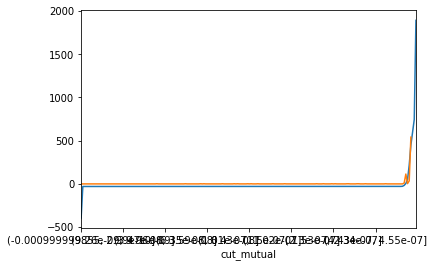

In [107]:
new_lls.plot()
lls.plot()

In [109]:
total_path['lls']=total_path['weighted_mutual'].map(new_lls)

In [110]:
total_path.head()

,gene_one,gene_two,goldstandard,weighted_mutual,cut_mutual,lls
0,562.22628.con.0001_286|562.22628,562.22434.con.0034_24|562.22434,0,1.713454e-08,"(1.71e-08, 1.78e-08]",-29.906439
1,562.22628.con.0001_286|562.22628,562.22438.con.0003_278|562.22438,0,2.351837e-07,"(2.34e-07, 2.42e-07]",-29.745527
2,562.22628.con.0001_286|562.22628,562.22453.con.0099_8|562.22453,0,6.100460e-08,"(6.1e-08, 6.22e-08]",-29.874227
3,562.22628.con.0001_286|562.22628,562.22453.con.0100_2|562.22453,0,1.541439e-07,"(1.53e-07, 1.55e-07]",-29.806813
4,562.22628.con.0001_286|562.22628,562.22457.con.0021_39|562.22457,0,1.005579e-07,"(9.95e-08, 1.01e-07]",-29.846028


In [ ]:
total_go = merge_gold(gold_go, d)

In [ ]:
return_stats(total_go)

In [ ]:
kde_d(total_go)

In [ ]:
lls = LLS(total_go, 'weighted_mutual')

In [ ]:
lls.plot(kind = 'bar', ylim = (0,30))

In [ ]:
lls.loc[lls>3]

In [ ]:
# set threshold at 5 * 10e-7

In [ ]:
def select_network(infile, outfile, thres):
    chunks = pd.read_csv(infile, header = 0, chunksize = 100000)
    for chunk in chunks:
        selected = chunk.loc[chunk['weighted_mutual'] > thres]
        with open(outfile, 'a') as f:
            selected.to_csv(f, header = 0, index = False)
        print(selected.shape)

In [ ]:
select_network('/home/hermuba/data0118/domain_weight_mutual', '/home/hermuba/data0118/network1122/domain_weight_mutual_select', thres = 0.0000005)